<a href="https://colab.research.google.com/github/hank199599/data_science_from_scratch_reading_log/blob/main/Chapter17.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 決策樹 (decision tree)

* 分類樹 (classification tree):輸出某個分類結果
* 回歸樹 (regression tree): 輸出某個數值結果  
  
需要決定以何種順序建立決策樹，決策樹的每個階段都能為我們消除某些可能性。  

# 亂度 (entropy；熵)

我們將一個問題「能帶出多少訊息」以**亂度**來表示。  
通常被用來表示混亂(disorder)的程度，  
在這裡則用來表示資料的不確定性(uncertainty)。

假設有一組資料S,其中每組資料都有分類標籤C₁,...,Cn。
* 所有資料點都屬於單一分類→不存在真正的不確性→低亂度
* 所有資料點均勻分布於各分類→具有相當程度的不確性→高亂度

## 數學上的術語
如果ρi是資料被標示為ci分類的比率，則亂度可定義為：


```
H(S) = -ρ₁㏒₂ρ₁-...-ρn㏒ρn
```
0log0=0


### 圖 17-2 -p㏒p的圖形


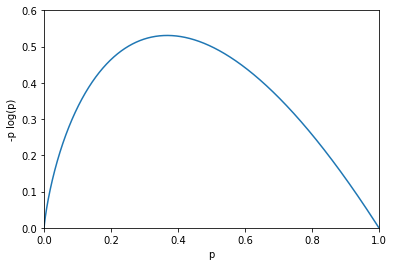

In [1]:
from matplotlib import pyplot as plt
import math

xs = [num/10000 for num in range(10000)]
ys = [0]+[-num*math.log(num,2) for num in xs if num>0]

plt.plot(xs,ys)
plt.xlabel("p")
plt.ylabel("-p log(p)")
plt.axis([0,1,0,0.6])
plt.show()


* 當每個p很接近0或1時，亂度值會很小
* 當每個p遠離0或1時，亂度值就會相對變大

In [2]:
from typing import List
import math

def entropy(class_probabilities:List[float])->float:
  """給定分類機率列表，計算出亂度"""
  return sum(-p*math.log(p,2) for p in class_probabilities if p > 0) #忽略機率為零的項目


In [3]:
assert entropy([1,0])==0

In [4]:
assert entropy([0.5,0.5])==1

In [5]:
assert entropy([0.25,0.75]) < 0.82

資料由(input,label)形式的成對資料所組成→我們需要自己計算出分類機率。

In [6]:
from typing import Any
from collections import Counter

def class_probabilities(labels:List[Any]) ->List[float]:
  total_count = len(labels)
  return [count/total_count for count in Counter(labels).values()]

def data_entropy(labels:List[Any])->float:
  return entropy(class_probabilities(labels))

In [7]:
assert data_entropy(['a']) == 0

In [8]:
assert data_entropy([True,False]) == 1

In [9]:
assert data_entropy([3,4,4,4,]) == entropy([0.25,0.75])

## 切分亂度

* 資料切分後所得的子集合亂度較低→切分亂度較低
* 資料切分後所得的子集合亂度較高→切分亂度較高


數學上，若我們把資料S切成S₁,...,Sm這幾個子集合，其中包含ｑ₁,...,ｑm比例的資料。  
我們能取加權總合的方式來計算出切分亂度。
```
H = ｑ₁H(S₁)+...+ｑmH(Sm)
```


In [10]:
def partion_entropy(subsets:List[List[Any]]) -> float:
  """資料被切分為子集合後，送回相應的切分亂度"""
  total_count = sum(len(subset) for subset in subsets)

  return sum(data_entropy(subset) * len(subset) / total_count for subset in subsets)

# 建立決策樹
* 決策節點(decision nodes):每個決策節點會詢問一個問題，並依據答案指往不同方向
* 樹葉節點(leaf nodes):每個樹葉節點代表一個預測結果

In [11]:
from typing import NamedTuple,Optional

class Candidate(NamedTuple):
  level:str
  lang:str
  tweets:bool
  phd:str
  did_well:Optional[bool]=None #接受未標記資料


In [12]:
inputs=[Candidate('Senior','Java',False,False,False),
    Candidate('Senior','Java',False,True,False),
    Candidate('Mid','Python',False,False,True),
    Candidate('Junior','Python',False,False,True),
    Candidate('Junior','R',True,False,True),
    Candidate('Junior','R',True,True,False),
    Candidate('Mid', 'R',True,True,True),
    Candidate('Senior','Python',False,False,False),
    Candidate('Senior','R',True,False,True),
    Candidate('Junior','Python',True,False,True),
    Candidate('Senior','Python',True,True,True),
    Candidate('Mid', 'Python',False,True,True),
    Candidate('Mid', 'Java',True,False,True),
    Candidate('Junior','Python',False,True,False)]

## 利用**ID3演算法**來建立決策樹：Greedy Method(貪婪法則)
* 如果所有資料全都具有相同的label 標籤,就建立一個樹葉節點,預測值就是該label 標籤值,然後就可以停止下來了。
*  如果屬性列表是空的(已經沒有更多問題可以問了),就建立一個樹葉節點,以資料中出現最多次的label 標籤做為預測值,然後也就可以停止下來了。

* 要不然的話,就試著根據每個屬性,對資料進行切分。 選出切分亂度最低的那個切分方式。

* 根據所選的屬性,添加一個決策節點。

* 運用剩餘的屬性,對每個被切分的子集合重複進行相同的動作。

In [13]:
from typing import Dict,TypeVar
from collections import defaultdict

T = TypeVar('T') # 輸入通用型別

def partition_by(inputs:List[T],attribute:str) ->Dict[Any,List[T]]:
  """根據指定的屬性，把輸入分派到不同的列表中"""
  partitions:Dict[Any,List[T]] = defaultdict(list)

  for input in inputs:
    key = getattr(input,attribute) # 取得指定屬性的值
    partitions[key].append(input)   #再把input添加到正確的列表中

  return partitions

計算亂度的函式

In [14]:
def partition_entropy_by(inputs:List[Any],attribute:str,label_attribute:str)->float:
  """計算出給定切分結果相應的切分亂度"""
  #partitions是由許多inputs所組成
  partitions=partition_by(inputs,attribute)

  #partition_entropy只需要類別標籤
  labels = [[getattr(input,label_attribute) for input in partition] for partition in partitions.values()]

  return partion_entropy(labels)

針對整個資料集，找出亂度最小的切分方式(尋找最佳解)

In [15]:
for key in ['level','lang','tweets','phd']:
  print(key,partition_entropy_by(inputs,key,'did_well'))

level 0.6935361388961919
lang 0.8601317128547441
tweets 0.7884504573082896
phd 0.8921589282623617


1. 依據level程度作切分所得的亂度最低
2. 中等(Mid)程度的求職者，相應的標籤都是True
3. 資深(Senior)的求職者，相應標籤有True亦有False
→**須對此再進行一次切分**

In [16]:
senior_inputs = [input for input in inputs if input.level=='Senior']

for key in ['lang','tweets','phd']:
  print(key,partition_entropy_by(senior_inputs,key,'did_well'))

lang 0.4
tweets 0.0
phd 0.9509775004326938


該結果告訴我們，下一個切分的屬性是tweets。  
對於那些**資深**的求職者來說：
* tweets屬性為yes的求職者：對應到True標籤
* tweets屬性為no的求職者：對應到False標籤

In [17]:
junior_inputs = [input for input in inputs if input.level=='Junior']

for key in ['lang','tweets','phd']:
  print(key,partition_entropy_by(junior_inputs,key,'did_well'))

lang 0.9509775004326938
tweets 0.9509775004326938
phd 0.0


對於**資遣**(Junior)的求職者，則選擇以phd欄位進行切分

### 圖 17-3 朝聘決策樹
![](https://lh3.googleusercontent.com/8ewTEWu5VPfDGOeUjxOGqGHpWXybLu_dw5jdo5tfxigdZL-z8xuNhRa1ZFRATwm7lz_YmkcjrMI_nzE9O9diQhPiTOtI9Hwq6CVeWrCdMpNtts1j2y6SI_CR96aUTsMbyNWxinE4XdegqDx9R0heriFcOCIpK6qFqVT7K4jaSI1_VBZlZpHlHvCLId6bS9AIG9gC1DwfONyYfoQR9Vvkn3mPZdiomSeZ5rN0hG2vPAgSDYpjDXQ8t2mIgPbn2CpEV_r4pcIA9a46JncF4QCKdm46HnKaRg_mOXnJqwuGW7ujhEH7fmjCU3HIardygpwdAAmI-eqoVGiS2ePQblzWfcgEhg_oZCWoliFQYp35ZYvXQKAr5lwEe6GzRSmmpgTbZ9e9tGBy0z2N6ZLPba4fphJ84cNIxTAMU1HB9SgL9lq275jJh19gtf2F8-2WsKhtZD5AkM3yckMcV1tpnlCBMLLfF-G2nMeI6MhlXWhEuxxYyOF5k_EmKPupA0uobW0KBsINMklauzZ16oK2ImBtK5IhqYcTIjoLdzkd5y3f1N3pejNfvvDGvNNKmzJXvUmmJXD7v2wiTjaMJSLN1HmEaqUHIgeLe4BBfAFjv_JhBrjRg2jN5U1bXfEVwBEX9Vd8IHNJUYpCdRsjuz5poEfORDyUImJkVdozec2UbutmbWhLURdC8w0n2_2oyKHcyQ=w695-h446-no?authuser=0)

## 定義決策樹
* 樹葉 (Left)：預測單一值
* 切分 (Split): 包含要切分的屬性、特定屬性相應的子樹、遇到未知值可使用的預測值




In [18]:
from typing import NamedTuple,Union,Any

class Leaf(NamedTuple):
  value:Any

class Split(NamedTuple):
  attribute:str
  subtrees:dict
  default_value:Any = None

DecisionTree = Union[Leaf,Split]

將招聘決策樹以Split物件的形式表示：

In [19]:
hiring_tree=Split('level',{
    'Junior':Split('phd',{False:Leaf(True),True:Leaf(False)}),
    'Mid':Leaf(True),
    'Senior':Split('tweets',{False:Leaf(False),True:Leaf(True)})
})

若遇到非預期的屬性值，可以用default_value來處理這情況。

In [20]:
def classify(tree:DecisionTree,input:Any)->Any:
  """用給定的決策樹，對輸入進行分類"""

  # 如果是個樹葉節點，就返回其值
  if isinstance(tree,Leaf):
    return tree.value
  
  # 要不然的話，該決策樹就以某個屬性進行切分 
  # 字典的鍵值就是屬性值
  # 鍵值的相應值就是接下來要考慮的子樹
  subtree_key = getattr(input,tree.attribute)

  if subtree_key not in tree.subtrees: # 如果鍵值沒有相應的子樹
    return tree.default_value      # 就送回預設值
  
  subtree = tree.subtrees[subtree_key]  # 選擇適當的子樹
  return classify(subtree,input)      # 然後用它對輸入進行分類

根據訓練資料建立決策樹的表示方式

In [21]:
def build_tree_id3(inputs:List[Any],split_attrabutes:List[str],target_attribute:str)->DecisionTree:

  # 算一下目標標籤的數量
  label_counts = Counter(getattr(input,target_attribute) for input in inputs)

  most_common_label = label_counts.most_common(1)[0][0]

  # 如果只有一個獨特的標籤，則用它來預測結果
  if len(label_counts) == 1:
    return Leaf(most_common_label)
  
  # 如果已經沒有屬性可切分，就送回數量占最多的標籤
  if not split_attrabutes:
    return Leaf(most_common_label)
  
  # 否則就根據最佳屬性進行切分

  def split_entorpy(attributes:str) ->float:
    """用來找出最佳屬性的輔助函式"""
    return partition_entropy_by(inputs,attributes,target_attribute)
  
  best_attribute = min(split_attrabutes , key=split_entorpy)

  partitions = partition_by(inputs,best_attribute)
  new_attributes = [a for a in split_attrabutes if a != best_attribute]

  # 以遞迴的方式建構子樹
  subtrees = {attribute_value:build_tree_id3(subset,new_attributes,target_attribute) for attribute_value,subset in partitions.items()}

  return Split(best_attribute,subtrees,default_value = most_common_label)

此決策樹可對訓練資料做出完美的預測，但也可以把它運用在訓練及以外的全新資料上。

In [22]:
tree = build_tree_id3(inputs,['level','lang','tweets','phd'],'did_well')

In [24]:
# 應該預測 True
classify(tree,Candidate("Junior","Java",True,False))

True

In [25]:
# 應該預測 True
classify(tree,Candidate("Junior","Java",True,True))

False

即使遇到資料遺漏或出現非預期的資料，也不會有問題。

In [26]:
# 應該預測 True
classify(tree,Candidate("Intern","Java",True,True))

True

# 隨機樹林(randomforests)

建立多個決策樹，並將他們的輸出組合起來。
* 數顆**分類**決策樹：進行投票
* 數顆**迴歸**決策樹：取所有預測值的平均值

利用隨機取樣，來訓練每一顆決策樹。  
  
**優點**：
* 由於每顆決策樹都是利用不同的資料建立起來的，每棵樹之間會有些許不同。
* 提供隨機性的來源→改變選擇的**最佳屬性**

## 整體學習(ensemble learning)
結合多個較弱的學習模型，並創造出整體而言較強的模型

In [ ]:
# 如果選擇數量很少，則全部採用
if len(split_candidates) <= self.num_split_candidates:
  sampled_split_candidates = split_candidates
# 或者取其中一小部分
else:
  sampled_split_candidates = random.sample(split_candidates,self.num_split_candidates)

# 現在，只根據這些可選項目，挑選出其中最佳屬性
best_attribute = min(sampled_split_candidates,key=split_entropy)

partitions = partition_by(inputs,best_attribute)